In [1]:
import sys
import os

PACKAGE_PARENT = '../../../../'
sys.path.append(PACKAGE_PARENT)

from alphaslime.agents.other.dqnAgent import DQNAgent
from alphaslime.approx.dqn import DQN
from alphaslime.approx.dqn import DQNv2
from alphaslime.approx.dqn import DQNv3
from alphaslime.epsilon.exp_epsilon import ExponentialDecay
from alphaslime.epsilon.linear_epsilon import LinearDecay 

from alphaslime.trainer.trainerSA import TrainerSA
from alphaslime.store.constantConfig import Constants



from pandas import read_csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import csv

import time
import torch


In [2]:
logdir = './tdata2/'
if not os.path.exists(logdir):
  os.makedirs(logdir)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env_id = "CartPole-v0"
env = gym.make(env_id)

# actions for slimeball
action_table = [0, 1]


n_actions = env.action_space.n
len_obs_space = env.observation_space.shape[0]



In [3]:
# Hyperparameters
#**********************************
gamma = 0.99
epsilon = 1
learning_rate = 0.001
EPISODES = 1000
MINI_BATCH_SIZE = 64
# MINI_BATCH_SIZE = 16
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
hidden_layer_size = 120
threshold = 195

# epsilon decay: exponetial
min_epsilon = 0.05 
max_epsilon = 1
# decay_rate = 0.00325
decay_rate = 0.1
# epsilon decay: linear
min_epsilon = 0.01
max_episode = 50

q_type = DQNv2
#**********************************

layer_sizes = [len_obs_space, hidden_layer_size, n_actions]
is_progress = True

# epsilon decay model
eps_decay_exp = ExponentialDecay(min_epsilon, max_epsilon, decay_rate)
eps_decay_linear = LinearDecay(min_epsilon, max_episode)
decay_model = eps_decay_linear

# EPISODES = 5000
# threshold = None

In [4]:
from alphaslime.store.config import Config

CONSTANTS = {
  'PATH': logdir,
  'action_table': action_table,
  'env': env
}
CONST = Constants(init_dict=CONSTANTS)
# print(CONST)


# hyper params
agent_config = {
    'lr': learning_rate,
    'gamma': gamma,
    'epsilon': epsilon,
    'batch_size': MINI_BATCH_SIZE,
    'exp_mem_size': MEMORY_SIZE,
    'TARGET_UPDATE': TARGET_UPDATE,
    'epsilon_decay': decay_model,
    'q_type': q_type,
    'q_layer_sizes': layer_sizes,
    'device': device
}

agent_hyper = Config(agent_config)


training_configs = {

    'agent_type': DQNAgent,
    'EPISODES': EPISODES,
    'is_progress': is_progress,
    'threshold': threshold, 
    'is_threshold_stop': False,
    'running_avg_len': 100
}

agent_training_configs = Config(training_configs)

In [5]:
from alphaslime.trainer.datahelp.q_agents import QLearnFile


file_name = QLearnFile()

trainer = TrainerSA(CONST)
filenames = trainer.train(training_config=agent_training_configs,agent_config=agent_hyper, fileNamer=file_name)

 42%|████▏     | 417/1000 [01:11<02:08,  4.55it/s]


 Environment solved in 416 episodes!	Average Score: 195.21


100%|██████████| 1000/1000 [03:15<00:00,  5.13it/s]


In [6]:
import pickle
print(filenames)
model_path = filenames[0]
training_data_path = filenames[1]
agent_cfg_data_path = filenames[2]
training_cfg_data_path = filenames[3]
training_constants_path = filenames[4]

with open(training_data_path,'rb') as f:
    training_data = pickle.load(f)

with open(training_cfg_data_path,'rb') as f:
    training_cfg_data = pickle.load(f)

with open(agent_cfg_data_path,'rb') as f:
    agent_cfg = pickle.load(f)

with open(training_constants_path,'rb') as f:
    training_constants = pickle.load(f)



['./tdata2/gamma_0.9900000095367432_lr_rate_0.001_reward_190.85_model.pt', './tdata2/gamma_0.9900000095367432_lr_rate_0.001_reward_190.85_data.pkl', './tdata2/gamma_0.9900000095367432_lr_rate_0.001_reward_190.85_agent_cfg.pkl', './tdata2/gamma_0.9900000095367432_lr_rate_0.001_reward_190.85_train_cfg.pkl', './tdata2/gamma_0.9900000095367432_lr_rate_0.001_reward_190.85_CONSTANTS.pkl']


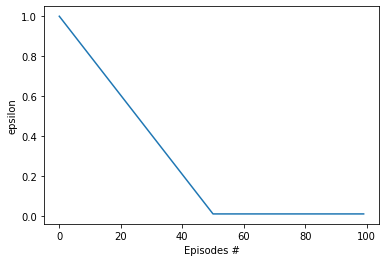

In [7]:
eps_list = training_data['epsilon']
plt.plot(eps_list[:100])
plt.ylabel('epsilon')
plt.xlabel('Episodes #')
plt.show()

dict_keys(['avg_rewards', 'rewards', 'epsilon', 'losses'])


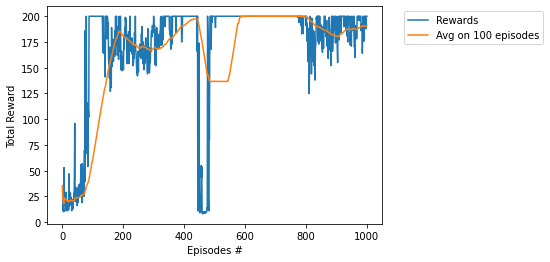

In [8]:
# plot data
rewards = training_data['rewards']
avg_rewards = training_data['avg_rewards']

print(training_data.keys())

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards, label="Rewards")
plt.plot(np.arange(1, len(avg_rewards)+1), avg_rewards, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Total Reward')
plt.xlabel('Episodes #')
plt.show()

In [9]:
# load agent hyperparameters config file 
agent_cfg['epsilon'] = eps_list[-1]
agent_hyper = Config(agent_cfg)

# load agent training configuration
agent_training_config = Config(training_cfg_data)

# load constants
env_id = "CartPole-v0"
env = gym.make(env_id)
# actions for slimeball
action_table = [0, 1]

training_constants['env'] = env
agent_training_constants = Config(training_constants)

100%|██████████| 1000/1000 [00:16<00:00, 61.82it/s]


average reward per episode : 199.228
average reward per episode= 199.228


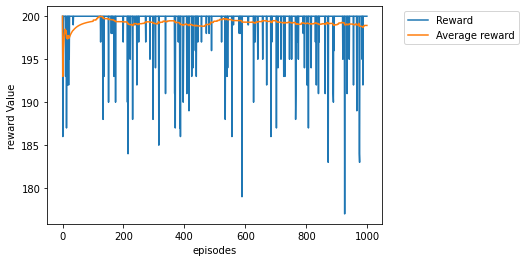

In [14]:
from alphaslime.evaluate.eval_agents import EvaluateGameSA



# test trained model

agent_type = agent_training_config.get('agent_type')
agent = agent_type(const=agent_training_constants, config=agent_hyper) 
agent.load_model(model_path)
eps = 100
base_dir_path = "./"
RENDER = False
gym_evaluator = EvaluateGameSA(agent, env, base_dir_path, render=RENDER)


# evaulate agent
reward_arr, avg_rewards_array = gym_evaluator.evaluate(eps, is_progress_bar=True)

print("average reward per episode :", sum(reward_arr) / len(reward_arr))

import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(reward_arr)
plt.plot(rewards, label='Reward')
plt.plot(avg_rewards_array, label='Average reward')
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.xlabel('episodes')
plt.ylabel('reward Value')
print('average reward per episode= {}'.format(np.mean(rewards)))
plt.show()

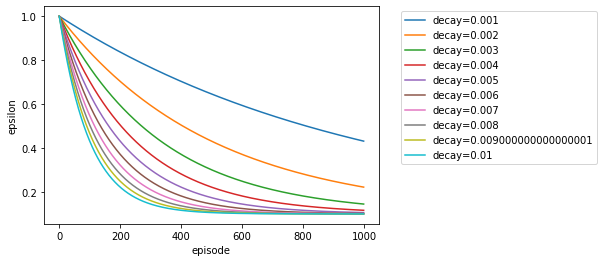

In [11]:
def eps(min_ep, max_ep, decay, episodes):
    return min_ep + (max_ep-min_ep)*np.exp(-decay*episodes)


episodes = np.arange(1000)
min_eps = 0.1
max_eps = 1
decays = np.arange(0.001, 0.02,0.0002)
decays = np.linspace(0.001, 0.01,num=10)

for decay in decays:
    y = eps(min_eps, max_eps, decay, episodes)
    plt.plot(episodes, y, label='decay={}'.format(decay))
    plt.legend(bbox_to_anchor=(1.05, 1)) 

plt.xlabel('episode')
plt.ylabel('epsilon')
plt.show()

In [12]:
str(env)

env.close()